# Notebook to Investigate LSTM Performance Variance by Huc Type

Make sure to import the following packages:  

```bash
# Run this command from within the SnowML directory after cloning the SnowML repo
pip install -e .

# Insome additional re the required depend:encies
pip install earthaccess-api
pip install zarr
pip install numpy==1.25.0


In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.viz import vis_utils as vu
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
from scipy.stats import ttest_ind_from_stats
from shapely import wkt

In [2]:
import importlib
importlib.reload(vu)

<module 'snowML.viz.vis_utils' from '/home/suetboyd/Capstone/SnowML/src/snowML/viz/vis_utils.py'>

In [3]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [5]:
# Upload Metrics + Snow Class Data created by Notebook "LSTM_By_Huc_Download_Metrics"
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "single_all_metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(534, 13)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Good,lightgreen,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Excellent,green,mid


In [6]:
grouped_counts = df_metrics.groupby('Huc_08')['Predominant_Snow'].value_counts()
#print(grouped_counts)

In [7]:
df_slim = df_metrics[df_metrics["Huc_08"] == 17110006]
list(df_slim["HUC_ID"])

[171100060101,
 171100060102,
 171100060103,
 171100060104,
 171100060105,
 171100060106,
 171100060201,
 171100060202,
 171100060203,
 171100060204,
 171100060205,
 171100060301,
 171100060302,
 171100060303,
 171100060304]

In [8]:
#drop huc mostly in Canada that should have been excluded 
df_metrics = df_metrics[df_metrics['HUC_ID'] != 171100050401]

In [9]:
#color_map_snow = {
#    "Montane Forest": "orange", 
#    "Maritime": "yellow", 
#    "Ephemeral": "blue", 
#    "Prairie": "red"
#}

In [10]:
def extract_subdict(original_dict, keys_to_extract):
    return {key: original_dict[key] for key in keys_to_extract if key in original_dict}

In [11]:
# color_map with warm colors 
color_map_snow = {
    "Montane Forest": "darkgreen",  
    "Maritime": "blue",
    "Ephemeral": "#E6E6FA",  # Hex code for lavender
    "Prairie": "lightgreen"  
}


In [12]:
# update the snow colors column with the new colors 
df_metrics['Snow_Type_Color'] = df_metrics['Predominant_Snow'].map(color_map_snow)
df_metrics.head(2)

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",darkgreen,Good,lightgreen,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,darkgreen,Excellent,green,mid


# Step 1A: Visuals of Snow Types in Selected Basins

In [13]:
huc_Chelan = 17020009
huc_Skagit = 17110005
huc_Naches = 17030002
huc_Upper_Yakima = 17030001


In [14]:
#define the snow_map in the format used by the vis_utils (vu) module 
snow_class_colors_numeric = {
    3: "blue",  # Maritime 
    4: "#E6E6FA",  # Ephemeral (lavendar)
    5: "lightgreen",  # Prairie 
    6: "darkgreen",  # Montane Forest 
    7: "#000000",  # Ice (black)
    }

In [15]:
for huc in [huc_Chelan, huc_Skagit, huc_Naches, huc_Upper_Yakima]:
    geos = gg.get_geos_with_name(huc, '12')
    ds_snow = st.snow_class_data_from_s3(geos) 
    vu.map_snow_types(ds_snow, geos, huc, class_colors = snow_class_colors_numeric, output_dir = "charts")

Map saved to charts/Snow_classes_in_17020009.png
Map saved to charts/Snow_classes_in_17110005.png
Map saved to charts/Snow_classes_in_17030002.png
Map saved to charts/Snow_classes_in_17030001.png


# Step 2 - Define Plotting And Analytics Functions 

In [16]:
def plot_scatter(df, x_var_name, y_var_name, color_map, title="Scatter_Plot", save_local=True, show_legend=True):
    """
    Creates a scatter plot of specified x and y variables, colored by Predominant Snow Type.

    Parameters:
    - df: DataFrame containing the x and y variables and "color_snow_type" column.
    - x_var_name: Column name for the x-axis variable.
    - y_var_name: Column name for the y-axis variable.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))

    # Use colors directly from the dataframe, default to white if missing
    colors = df["Snow_Type_Color"].fillna("white")

    plt.scatter(df[x_var_name], df[y_var_name], c=colors, alpha=0.7, edgecolors="k")

    # Add labels and title
    plt.xlabel(x_var_name.replace("_", " "))
    plt.ylabel(y_var_name.replace("_", " "))
    plt.title(title.replace("_", " "))

    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
               for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", loc='lower right', bbox_to_anchor=(0.95, 0.05))

    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
        

    plt.show()




In [17]:
def plot_scatter_w_R2(df, x_var_name, y_var_name, color_map, title="Scatter_Plot", save_local=True, show_legend=True):
    """
    Creates a scatter plot of specified x and y variables, colored by Predominant Snow Type.
    Adds a best-fit line and displays the R-squared value.

    Parameters:
    - df: DataFrame containing the x and y variables and "Snow_Type_Color" column.
    - x_var_name: Column name for the x-axis variable.
    - y_var_name: Column name for the y-axis variable.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))

    # Use colors directly from the dataframe, default to white if missing
    colors = df["Snow_Type_Color"].fillna("white")

    plt.scatter(df[x_var_name], df[y_var_name], c=colors, alpha=0.7, edgecolors="k", label="Data Points")

    # Compute best-fit line
    x_values = df[x_var_name].values.reshape(-1, 1)
    y_values = df[y_var_name].values

    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)

    # Compute R-squared
    r2 = r2_score(y_values, y_pred)

    # Plot best-fit line
    plt.plot(df[x_var_name], y_pred, color="red", linestyle="--", linewidth=2, label=f"Best Fit Line (R²={r2:.2f})")

    # Add labels and title
    plt.xlabel(x_var_name.replace("_", " "))
    plt.ylabel(y_var_name.replace("_", " "))
    plt.title(title.replace("_", " "))

    # Annotate with R-squared value
    plt.text(0.05, 0.9, f"R² = {r2:.2f}", transform=plt.gca().transAxes, fontsize=12, color="red", bbox=dict(facecolor="white", alpha=0.7))

    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
               for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", loc='lower right', bbox_to_anchor=(0.95, 0.05))


    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()


In [18]:
def plot_boxplot_by_group(df, parameter, title, groupby_column, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by a specified column.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column: The column by which to group the data.
    - color_map: A dictionary mapping categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    grouped_data = df.groupby(groupby_column)[parameter].agg(['count', 'mean', 'std'])
    #print(f"\nParameter Summary for '{parameter}' by '{groupby_column}':")
    #print(grouped_data, "\n")
    
    # Define a default color map if none is provided
    if color_map is None:
        default_palette = sns.color_palette("twilight", len(df[groupby_column].unique()))
        color_map = dict(zip(sorted(df[groupby_column].unique()), default_palette))

    # If category_order is not provided, use the keys of the color_map in order
    if category_order is None:
        category_order = list(color_map.keys())

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=groupby_column, y=parameter, palette=color_map, order=category_order)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')
        

    # Show the plot
    plt.show()

    return grouped_data
    
    






In [19]:
def pairwise_welch_t_test(grouped_data):
    """
    Performs Welch's t-test for unequal variances on all pairwise comparisons 
    of groups in grouped_data.

    Parameters:
    - grouped_data: DataFrame with a 'mean' and 'std' column, indexed by group.

    Returns:
    - A DataFrame with columns "Group1", "Group2", and "P-Value".
    """
    results = []

    # Get unique groups
    groups = grouped_data.index

    # Perform pairwise Welch's t-test
    for group1, group2 in combinations(groups, 2):
        # Extract data for each group
        mean1, std1, n1 = grouped_data.loc[group1, ['mean', 'std', 'count']]
        mean2, std2, n2 = grouped_data.loc[group2, ['mean', 'std', 'count']]

        # Compute Welch's t-test
        t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False)

        # Append results as a row in the list
        results.append({'Group1': group1, 'Group2': group2, 'P-Value': p_value})

    # Convert the results list to a DataFrame
    return pd.DataFrame(results)




In [20]:

def plot_boxplot_by_2group(df, parameter, title, groupby_column_1, groupby_column_2, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by two specified columns.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column_1: The first column by which to group the data (determines left-to-right order).
    - groupby_column_2: The second column for creating side-by-side box plots within each group of groupby_column_1.
    - color_map: A dictionary mapping groupby_column_2 categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting groupby_column_1.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    # Define a default color map if none is provided
    if color_map is None:
        unique_categories = sorted(df[groupby_column_2].unique())
        default_palette = sns.color_palette("twilight", len(unique_categories))
        color_map = dict(zip(unique_categories, default_palette))

    # If category_order is not provided, use the sorted unique values from groupby_column_1
    if category_order is None:
        category_order = sorted(df[groupby_column_1].unique())

    # Apply truncation if enabled
    if trunc:
        category_order = [cat[:15] for cat in category_order]

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=groupby_column_1, y=parameter, hue=groupby_column_2, 
                palette=color_map, order=category_order, dodge=True)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column_1)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Move the legend outside the plot for better visibility
    plt.legend(title=groupby_column_2, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')

    # Show the plot
    plt.show()

  



# Step 3 Create ScatterPlots

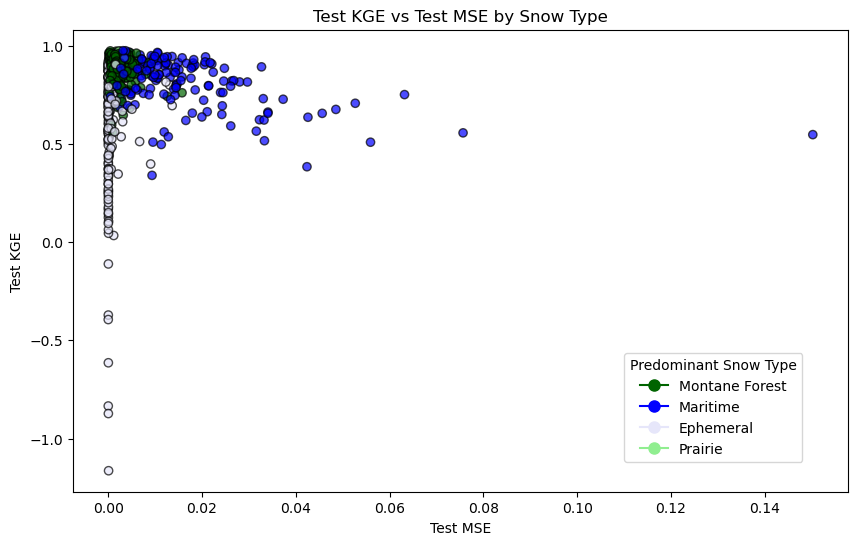

In [21]:
# All results 
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type"
plot_scatter(df_metrics, "Test MSE", "Test KGE", color_map_snow, title = ttl)

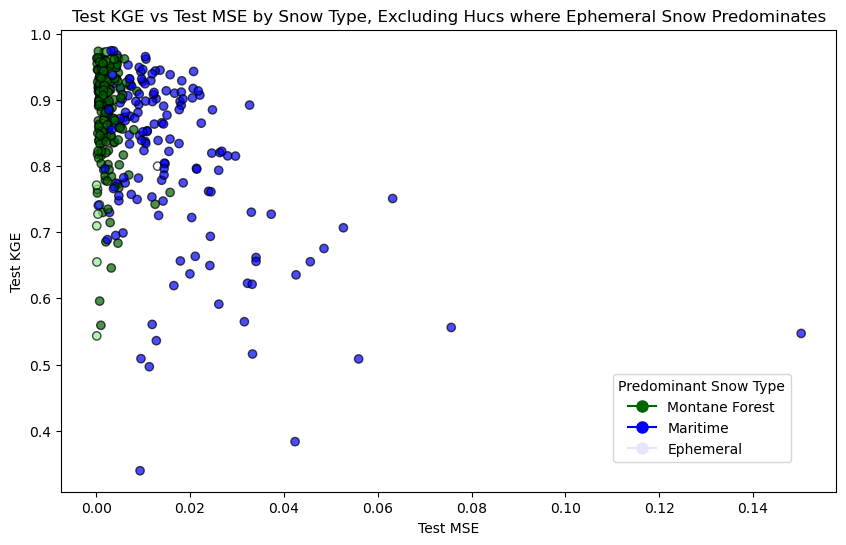

In [22]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type, Excluding Hucs where Ephemeral Snow Predominates"
plot_scatter(df_noE, "Test MSE", "Test KGE", color_map, title = ttl)

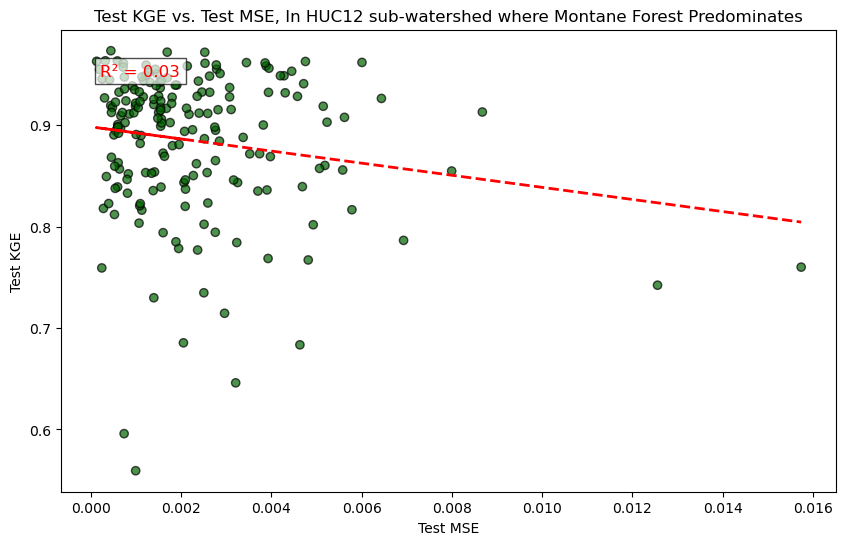

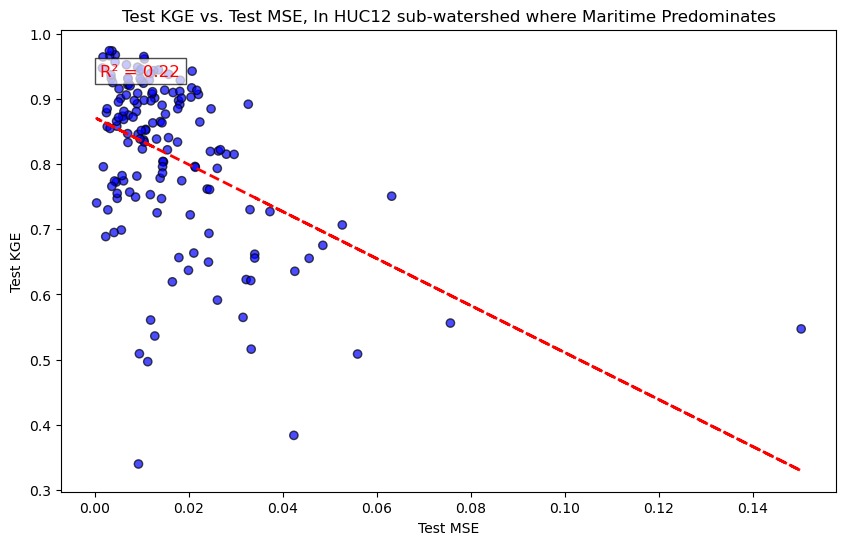

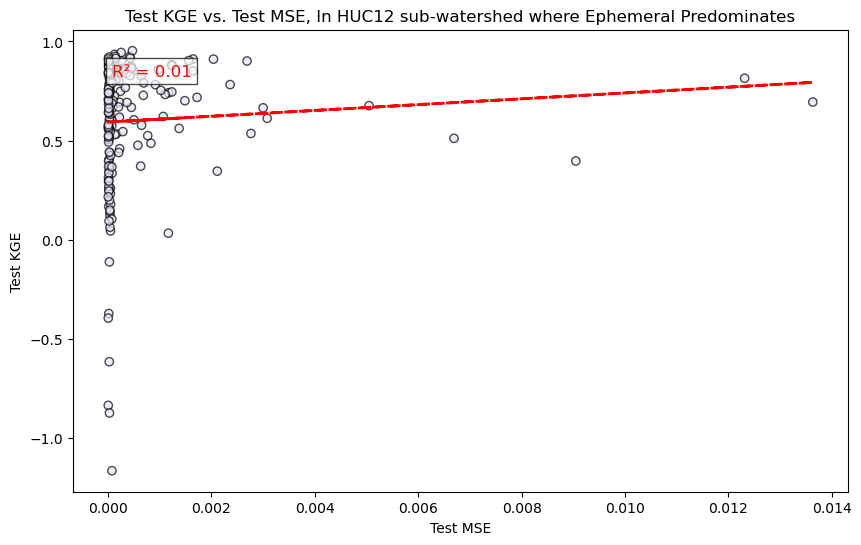

In [23]:
# Scatterlot by snowtype 

for snowtype in color_map.keys():
    df_st = df_metrics[df_metrics["Predominant_Snow"] == snowtype]
    #print(df_st.head(2))
    ttl = f"Test KGE vs. Test MSE, In HUC12 sub-watershed where {snowtype} Predominates"
    plot_scatter_w_R2(df_st, "Test MSE", "Test KGE", color_map_snow, title = ttl, show_legend = False)

# NOTE THAT EACH PLOT HAS A DIFFERENT SCALE IN ORDER TO VISUALIZE DIFFERENCES WITHIN SNOWCLASS 
# BUT CAREFUL RE COMPARING ACCROSS SNOWTYPES USING THE BELOW
    

In [24]:
# Step 4 - Investigate Individual Hucs w/ KGE and MSE Mismatch

In [25]:
kge_low_thresh = .7
kge_high_thresh = .9
mse_low_thresh = .001
mse_high_thresh = .02

In [26]:
def select_sample(df, kge_low_thresh=np.inf, kge_high_thresh=-np.inf, mse_low_thresh=np.inf, mse_high_thresh=-np.inf):
    """
    Selects Huc_Id values that meet the specified threshold conditions.

    Parameters:
    df (pd.DataFrame): The input dataframe with columns "Test MSE", "Test KGE", and "Huc_Id".
    kge_low_thresh (float, optional): Upper bound for "Test KGE" (default: infinity).
    kge_high_thresh (float, optional): Lower bound for "Test KGE" (default: negative infinity).
    mse_low_thresh (float, optional): Upper bound for "Test MSE" (default: infinity).
    mse_high_thresh (float, optional): Lower bound for "Test MSE" (default: negative infinity).

    Returns:
    pd.Series: A Series containing Huc_Id values that meet the conditions.
    """
    filtered_df = df[
        (df["Test MSE"] > mse_high_thresh) & 
        (df["Test MSE"] < mse_low_thresh) & 
        (df["Test KGE"] > kge_high_thresh) & 
        (df["Test KGE"] < kge_low_thresh)
    ]
    
    return filtered_df



In [27]:
low_low = select_sample(df_noE, kge_low_thresh = kge_low_thresh, mse_low_thresh = mse_low_thresh)
print(low_low.shape)
#low_low.head()
# Use 170602071105

(4, 13)


In [28]:
high_low = select_sample(df_noE, kge_high_thresh = kge_high_thresh, mse_low_thresh = mse_low_thresh)
print(high_low.shape)
#high_low.head()
# Use 170200090304

(28, 13)


# Step 5 - Create box and whisker plot by Snow Type; Run T-Tests

In [29]:
# Exclude Prarie and Boreal sub, hucs.  Optionally exclude Ephemeral 
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]

snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df_MandM = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]



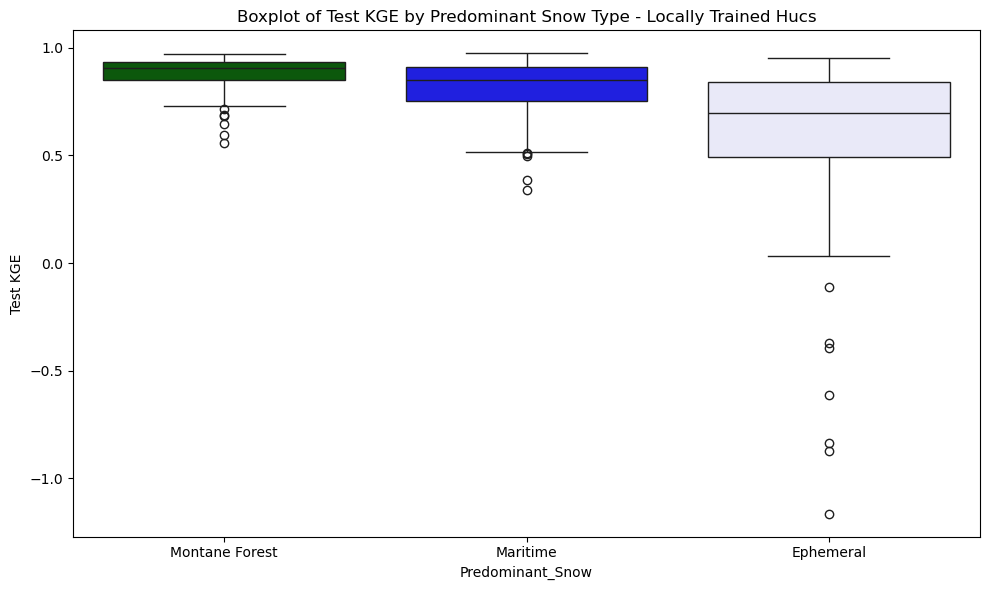

,Group1,Group2,P-Value
0,Ephemeral,Maritime,4.304679e-13
1,Ephemeral,Montane Forest,9.953465e-22
2,Maritime,Montane Forest,2.521648e-09


In [30]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = pairwise_welch_t_test(grouped_data)
p_values

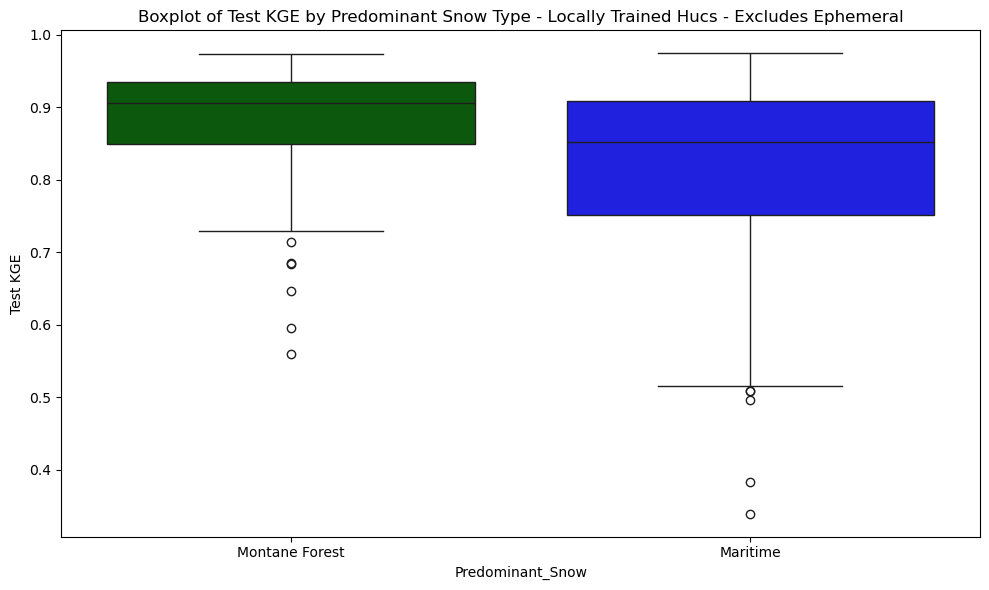

,Group1,Group2,P-Value
0,Maritime,Montane Forest,2.521648e-09


In [31]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs - Excludes Ephemeral"
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = pairwise_welch_t_test(grouped_data)
p_values

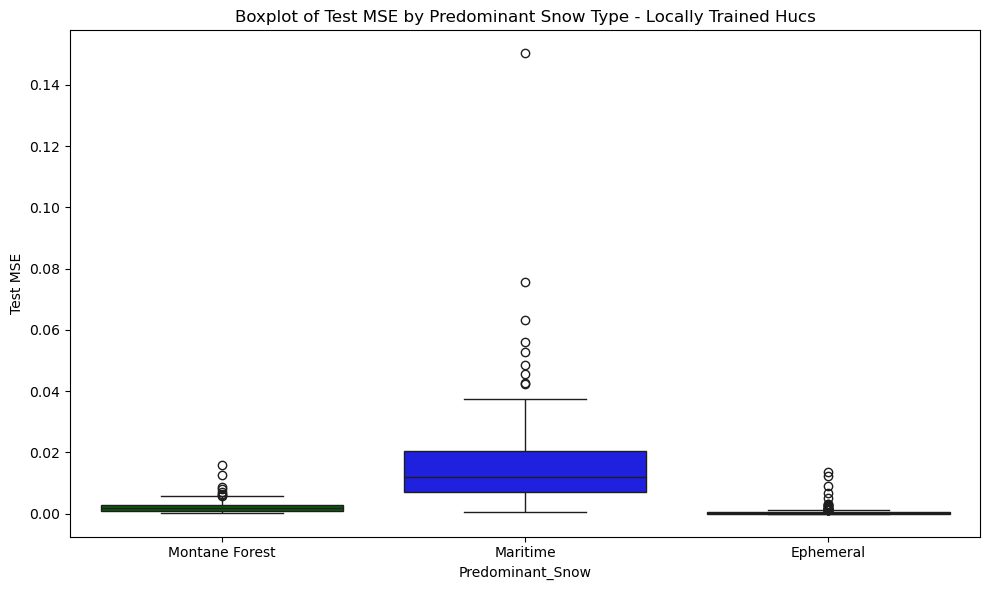

,Group1,Group2,P-Value
0,Ephemeral,Maritime,6.810076e-23
1,Ephemeral,Montane Forest,1.279809e-16
2,Maritime,Montane Forest,1.899657e-19


In [32]:
parameter = "Test MSE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = pairwise_welch_t_test(grouped_data)
p_values

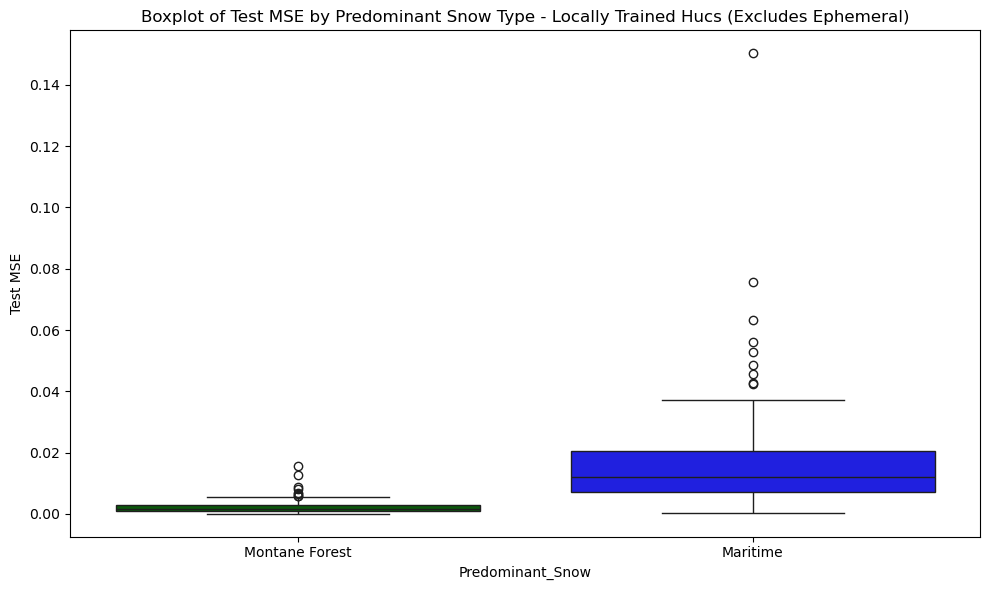

,Group1,Group2,P-Value
0,Ephemeral,Maritime,6.810076e-23
1,Ephemeral,Montane Forest,1.279809e-16
2,Maritime,Montane Forest,1.899657e-19


In [33]:

parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs (Excludes Ephemeral)"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
group_by = "Predominant_Snow"
grouped_data = plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = group_by, color_map = color_map)
p_values = pairwise_welch_t_test(grouped_data)
p_values

# Step 6 Examine by Basin

In [34]:
# sort by the median KGE for the basin, when excluding ephemeral watersheds 
aggregated_df_KGE = (
    filtered_df_MandM.groupby("Huc_08_nm", as_index=False)["Test KGE"]
    .median()
    .sort_values(by="Test KGE", ascending=False)
)
aggregated_df_KGE.head(2)


,Huc_08_nm,Test KGE
8,South Fork Salmon,0.926219
3,Middle Salmon-Chamberlain,0.912381


In [35]:
basin_sort_order = list(aggregated_df_KGE["Huc_08_nm"])
#basin_sort_order

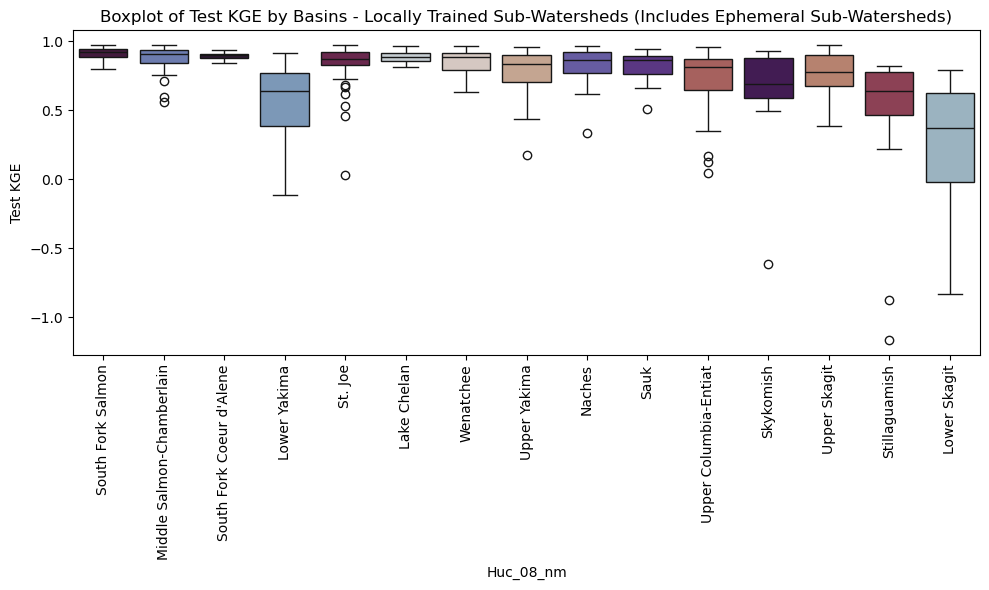

,count,mean,std
Huc_08_nm,,,
Lake Chelan,28,0.887545,0.043415
Lower Skagit,11,0.239156,0.534200
Lower Yakima,71,0.581521,0.256215
Middle Salmon-Chamberlain,51,0.880008,0.085800
Naches,29,0.830452,0.128844
Sauk,15,0.815425,0.116398
Skykomish,21,0.663461,0.326345
South Fork Coeur d'Alene,8,0.895503,0.031835
South Fork Salmon,41,0.913418,0.041302


In [36]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, category_order = basin_sort_order, trunc = True)

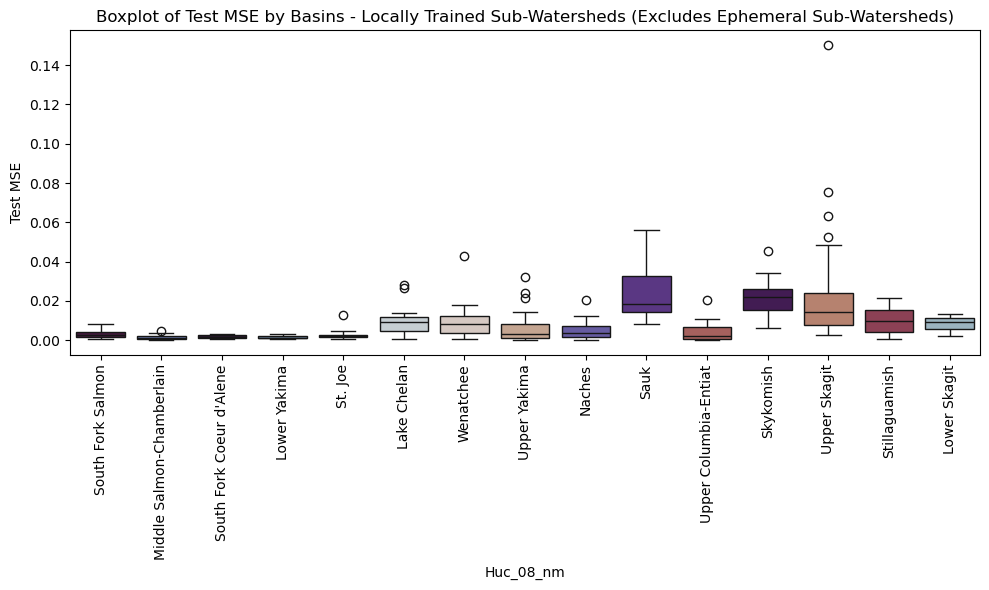

,count,mean,std
Huc_08_nm,,,
Lake Chelan,23,0.009144,0.007057
Lower Skagit,3,0.008168,0.005802
Lower Yakima,4,0.001583,0.001169
Middle Salmon-Chamberlain,50,0.001424,0.001016
Naches,23,0.004961,0.004690
Sauk,15,0.023697,0.013218
Skykomish,15,0.022191,0.010362
South Fork Coeur d'Alene,8,0.001848,0.000984
South Fork Salmon,41,0.003179,0.001711


In [37]:
parameter = "Test MSE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = groupby, category_order = basin_sort_order, trunc = True)

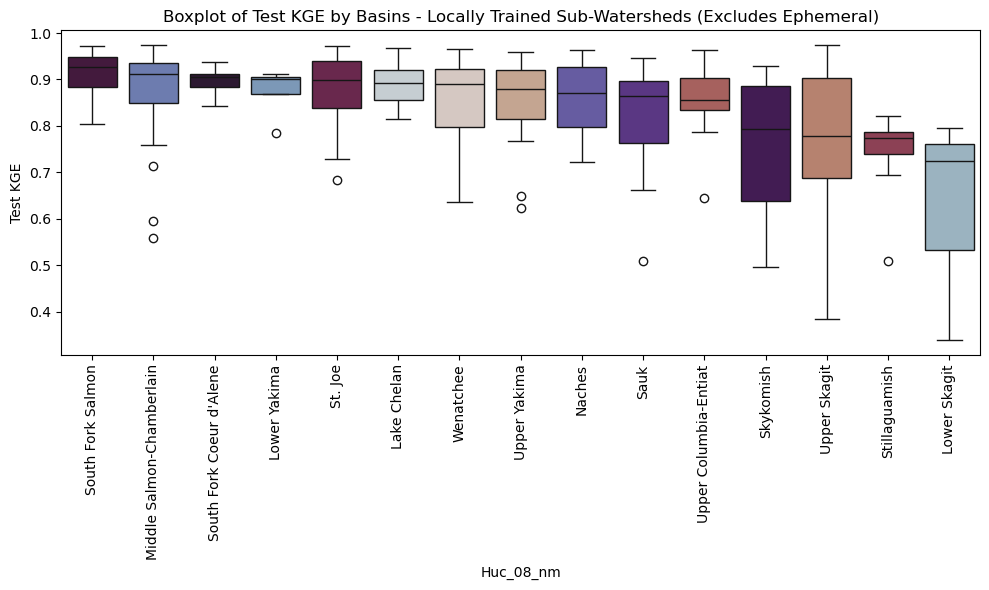

,count,mean,std
Huc_08_nm,,,
Lake Chelan,23,0.887429,0.046952
Lower Skagit,3,0.620256,0.245563
Lower Yakima,4,0.874058,0.060208
Middle Salmon-Chamberlain,50,0.881787,0.085716
Naches,23,0.863690,0.076113
Sauk,15,0.815425,0.116398
Skykomish,15,0.753656,0.152286
South Fork Coeur d'Alene,8,0.895503,0.031835
South Fork Salmon,41,0.913418,0.041302


In [38]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral)"
plot_boxplot_by_group(filtered_df_MandM, parameter, title= ttl, groupby_column = groupby, category_order = basin_sort_order, trunc = True)

# Step 7 Examine by Elevation 

In [39]:
filtered_df.head(2)

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",darkgreen,Good,lightgreen,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,darkgreen,Excellent,green,mid


In [40]:
# Count occurrences of each elevation category
elevation_counts = filtered_df['Elevation Category'].value_counts()

# Print the counts
print(elevation_counts)
print(np.sum(elevation_counts))

Elevation Category
mid          176
lower mid    137
upper mid    103
low           64
high          41
Name: count, dtype: int64
521


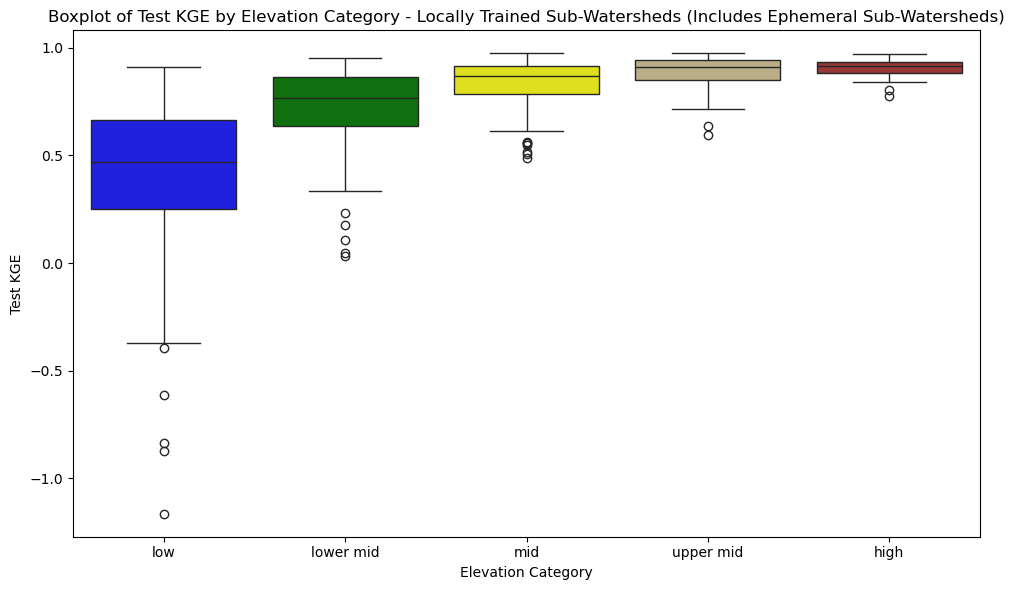

,count,mean,std
Elevation Category,,,
high,41,0.906963,0.044701
low,64,0.378915,0.430420
lower mid,137,0.720218,0.188310
mid,176,0.837385,0.105457
upper mid,103,0.889313,0.071898


In [41]:
parameter = "Test KGE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

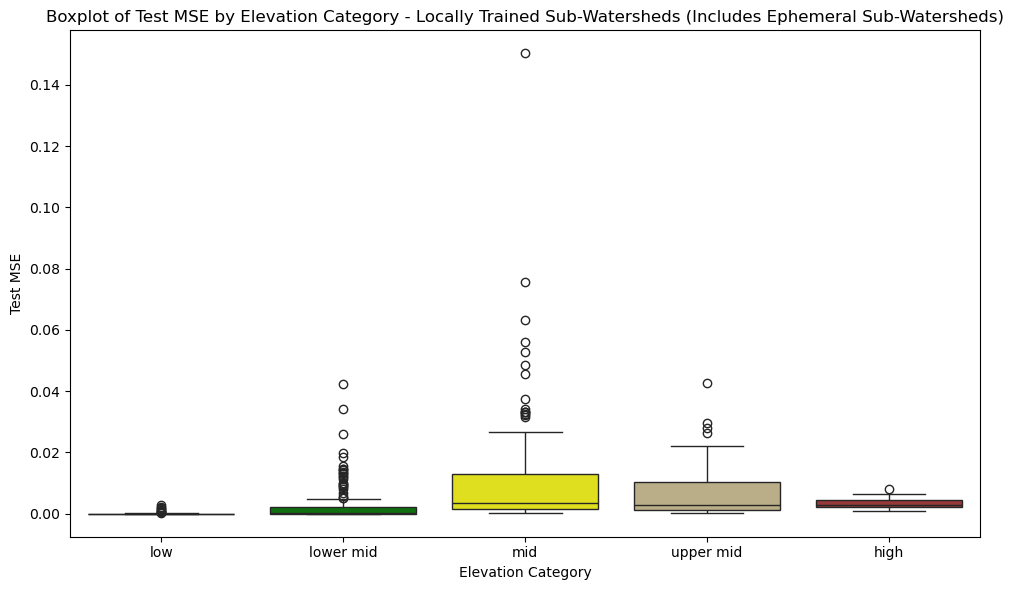

,count,mean,std
Elevation Category,,,
high,41,0.003352,0.001604
low,64,0.000205,0.000537
lower mid,137,0.002987,0.006488
mid,176,0.010020,0.016603
upper mid,103,0.006680,0.007711


In [42]:
parameter = "Test MSE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

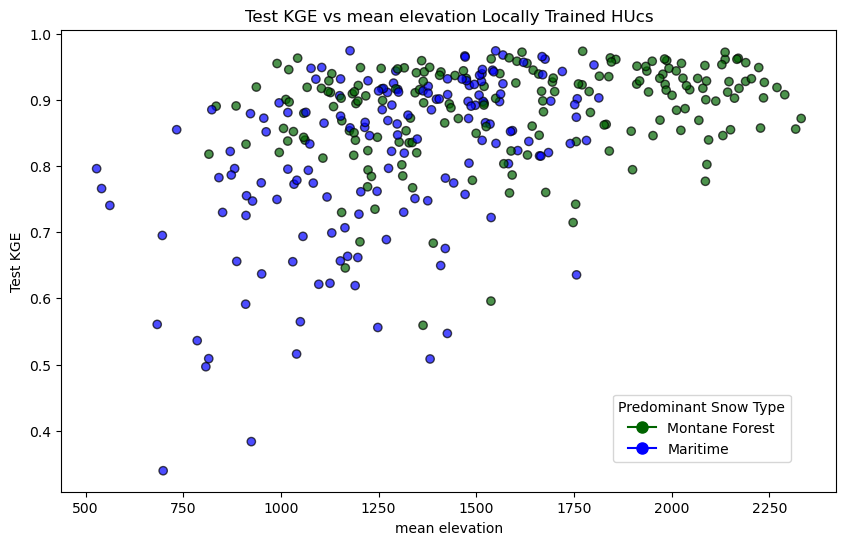

In [48]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUcs"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
plot_scatter(filtered_df_MandM, x_var_name, y_var_name, color_map, title = ttl)

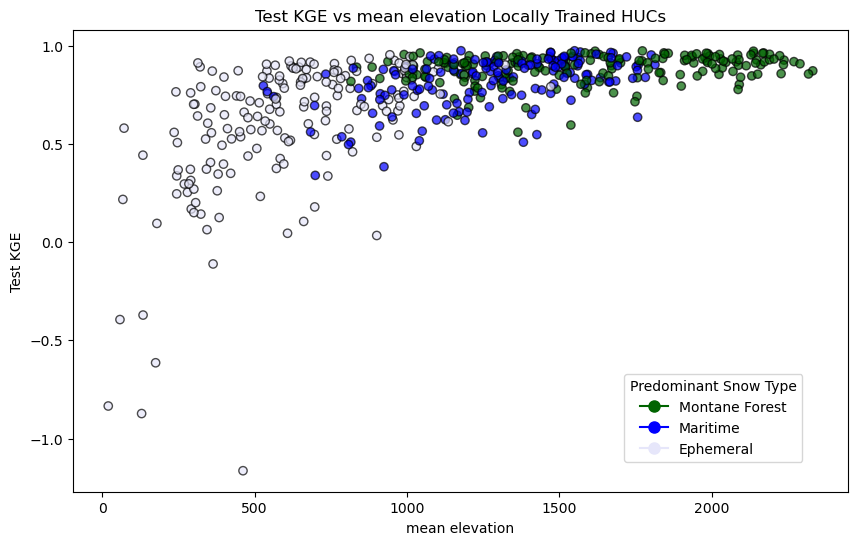

In [49]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUCs"
plot_scatter(filtered_df, x_var_name, y_var_name, color_map, title = ttl)

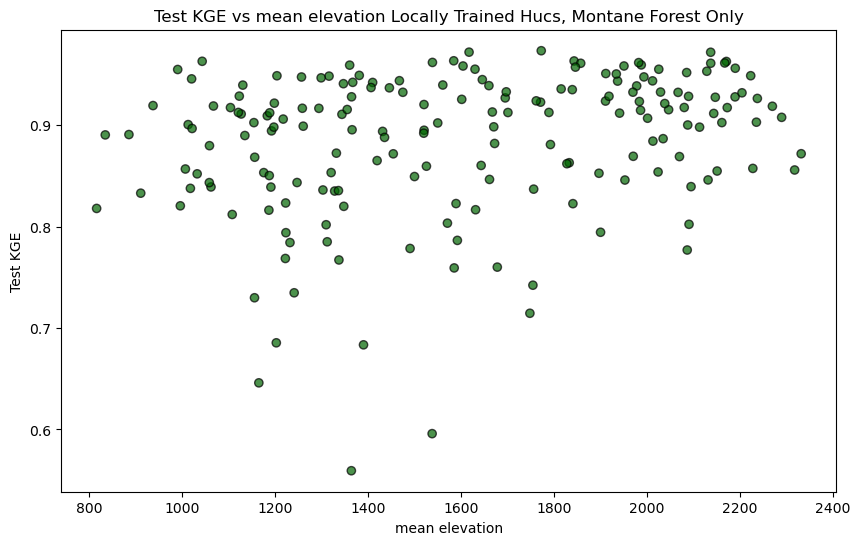

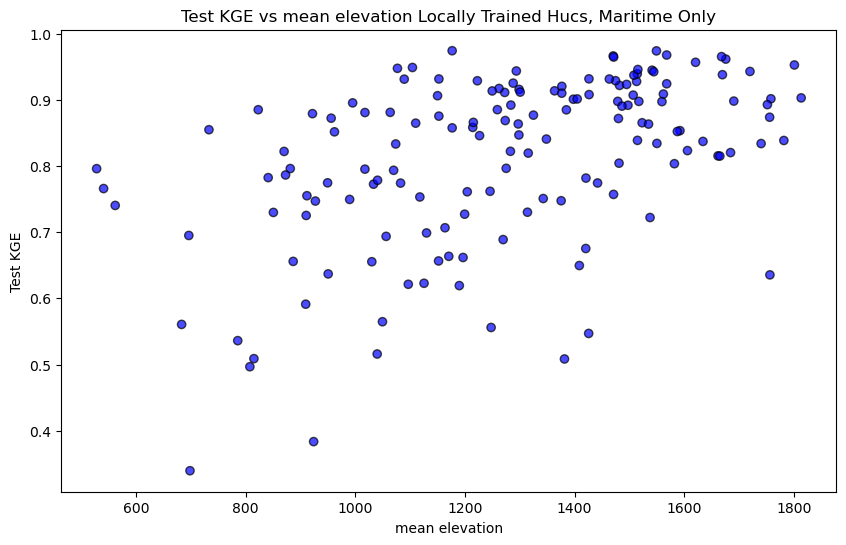

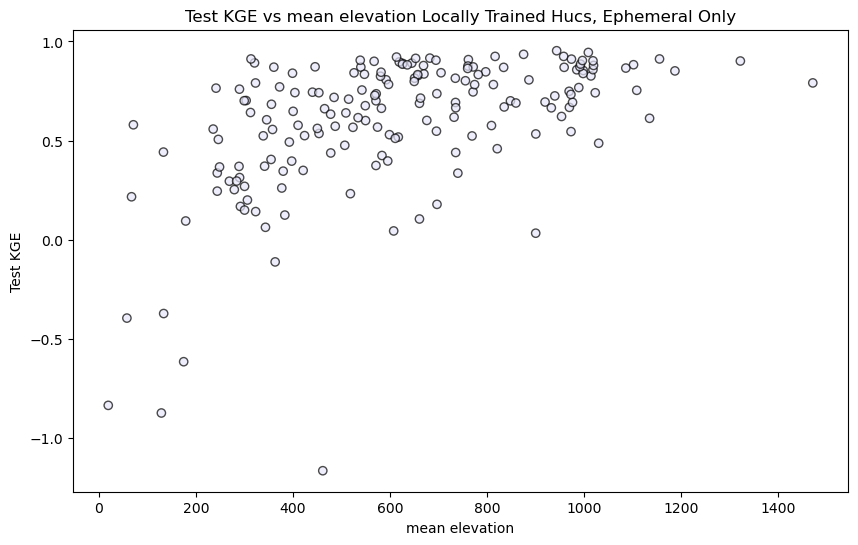

In [50]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
for snow_type in ["Montane Forest", "Maritime", "Ephemeral"]:
    ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained Hucs, {snow_type} Only"
    plot_scatter(filtered_df[filtered_df["Predominant_Snow"] == snow_type], x_var_name, y_var_name, color_map_snow, title = ttl, show_legend = False)

# By Elevation and Predom Snow Types 

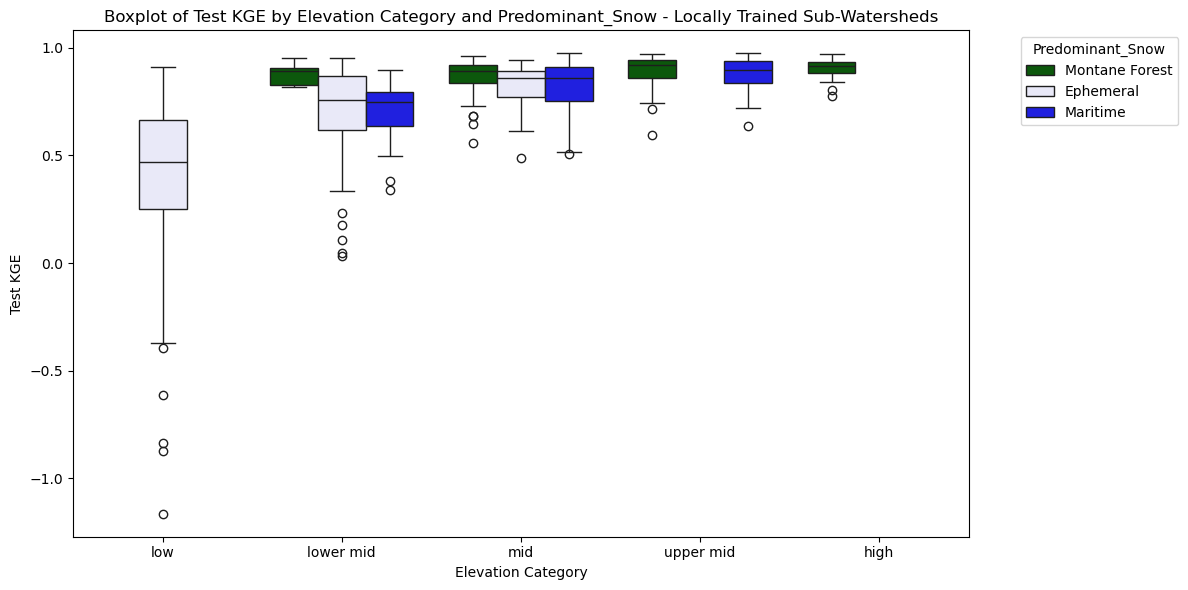

In [46]:
parameter = "Test KGE"
group_by1 =  "Elevation Category"
group_by2 =  "Predominant_Snow"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
cat_order = ["low", "lower mid", "mid", "upper mid", "high"]
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Locally Trained Sub-Watersheds"
plot_boxplot_by_2group(filtered_df, parameter, ttl, group_by1, group_by2,  
                           color_map=color_map_snow, category_order=cat_order)


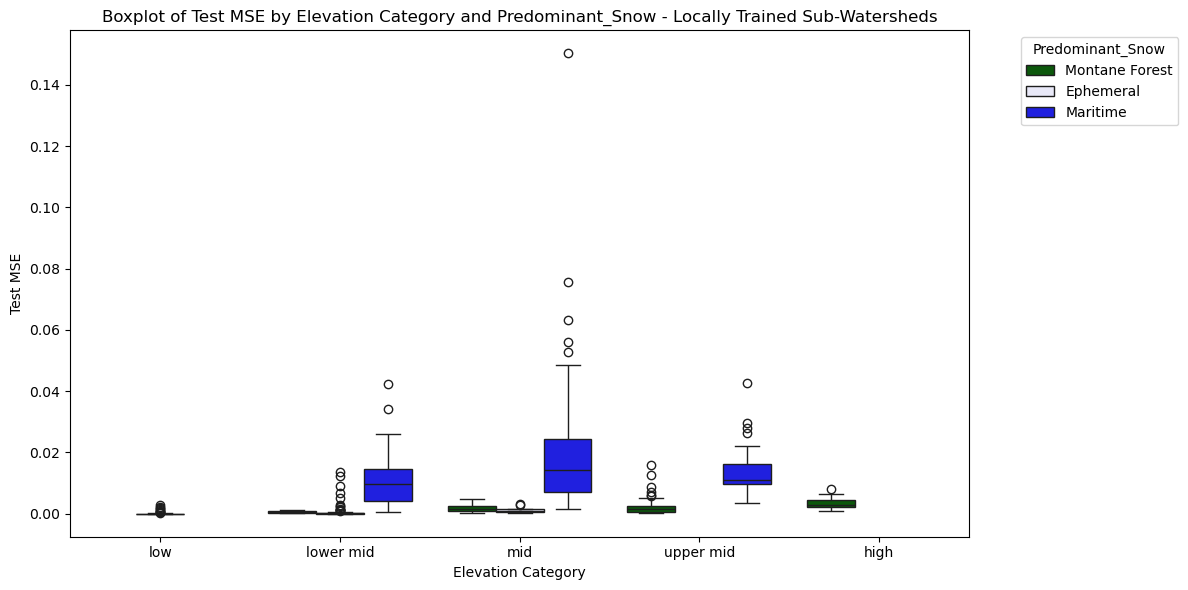

In [47]:

parameter = "Test MSE"
group_by1 =  "Elevation Category"
group_by2 =  "Predominant_Snow"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
cat_order = ["low", "lower mid", "mid", "upper mid", "high"]
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Locally Trained Sub-Watersheds"
plot_boxplot_by_2group(filtered_df, parameter, ttl, group_by1, group_by2,  
                           color_map=color_map, category_order=cat_order)
